In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from spikingjelly.clock_driven import functional, surrogate, neuron, layer
from spikingjelly.activation_based import spike_op as sn
from spikingjelly.activation_based import functional, surrogate, neuron, layer, encoding
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cupy

c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:84: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias, stride, padding, dilation, groups):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:110: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:152: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias=None):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\s

In [2]:
time_steps = 8
batch_size = 16
learning_rate = 1e-3
epochs = 100

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.ImageFolder(
    root='./dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(
    root='./dataset/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
import numpy as np
class CSNN(nn.Module):
    def __init__(self, T=8):
        super(CSNN, self).__init__()
        self.T = T
        self.layer1 = nn.Sequential(
            layer.Conv2d(1, 128, kernel_size=3, stride=1, padding=1,step_mode='s'),
            layer.BatchNorm2d(128,step_mode='s'),
        )
        self.layer2 = nn.Sequential(
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(),step_mode='m'),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            layer.BatchNorm2d(128),
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(),step_mode='m'),
            layer.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            layer.Flatten(),
            layer.Dropout(p=0.5),
            layer.Linear(128*12*12, 1152),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(),step_mode='m'),
            layer.Dropout(p=0.5),
            layer.Linear(1152, 128),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(),step_mode='m'),
            layer.Linear(128, 7),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(),step_mode='m')
        )

        functional.set_step_mode(self.layer2, step_mode='m')
        functional.set_step_mode(self.layer3, step_mode='m')
        functional.set_backend(self, backend='cupy')
        self.pe = encoding.PoissonEncoder()

    def forward(self, x):
        # x = self.pe(x)
        x = self.layer1(x)
        x_step = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        out1 = self.layer2(x_step)
        out2 = self.layer3(out1)
        # for t in range(self.T):
        #     x_time[t] = self.pe(x)
        # x_step = []
        # for t in range(self.T):
        #     out1 = self.layer2(x_time[t])
        #     out2 = self.layer3(out1)
        #     x_step.append(out2.unsqueeze(0))
        # x = torch.cat(x_step)
        return out2.mean(dim=0)


np.int = int

def train(model, loader, optimizer, criterion, mse=False):
    model.train()
    total_loss, correct = 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if mse:
          target_onehot = torch.nn.functional.one_hot(
              target, num_classes=7).float()
          loss = criterion(output, target_onehot)
        else:
          loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        correct += (output.argmax(dim=1) == target).sum().item()
        functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def validate(model, loader, criterion, mse=False):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if mse:
              target_onehot = torch.nn.functional.one_hot(
                  target, num_classes=7).float()
              loss = criterion(output, target_onehot)
            else:
              loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(dim=1) == target).sum().item()
            functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


# Initialize model, criterion, and optimizer
model = CSNN(T=4).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss().to(device)

mse = True if criterion._get_name() == 'MSELoss' else False

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []
# Train and Validate
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(
        model, train_loader, optimizer, criterion, mse=mse)
    val_loss, val_acc = validate(model, test_loader, criterion, mse=mse)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.4f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.4f}%")

Epoch 1: Train Loss: 0.1272, Train Acc: 18.2417%, Val Loss: 0.1208, Val Acc: 21.7331%
Epoch 2: Train Loss: 0.1131, Train Acc: 31.2585%, Val Loss: 0.1076, Val Acc: 32.5160%
Epoch 3: Train Loss: 0.1051, Train Acc: 37.7861%, Val Loss: 0.1005, Val Acc: 38.8548%
Epoch 4: Train Loss: 0.1017, Train Acc: 40.7956%, Val Loss: 0.0997, Val Acc: 45.2633%
Epoch 5: Train Loss: 0.0992, Train Acc: 43.2512%, Val Loss: 0.0963, Val Acc: 45.2494%
Epoch 6: Train Loss: 0.0977, Train Acc: 44.3972%, Val Loss: 0.0956, Val Acc: 42.1009%
Epoch 7: Train Loss: 0.0962, Train Acc: 45.7034%, Val Loss: 0.0949, Val Acc: 46.2942%
Epoch 8: Train Loss: 0.0955, Train Acc: 46.5185%, Val Loss: 0.0928, Val Acc: 45.9738%
Epoch 9: Train Loss: 0.0940, Train Acc: 46.8285%, Val Loss: 0.0935, Val Acc: 45.5977%
Epoch 10: Train Loss: 0.0932, Train Acc: 47.5948%, Val Loss: 0.0918, Val Acc: 46.1410%
Epoch 11: Train Loss: 0.0926, Train Acc: 48.1173%, Val Loss: 0.0928, Val Acc: 51.1842%
Epoch 12: Train Loss: 0.0913, Train Acc: 49.1727%, V

In [ ]:
# torch.save(model.state_dict(), 'sjcnn_final.pth')

In [ ]:
# model_data = {
#   "tloss": train_loss_hist,
#   "tacc": train_acc_hist,
#   "vloss": val_loss_hist,
#   "vacc": val_acc_hist
# }
# torch.save(model_data, 'sjcnn_train_data.pth')

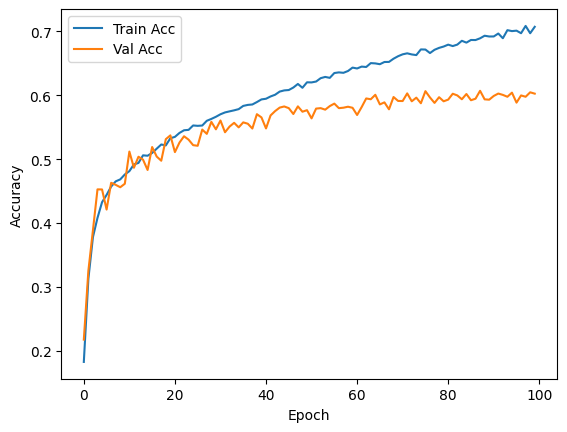

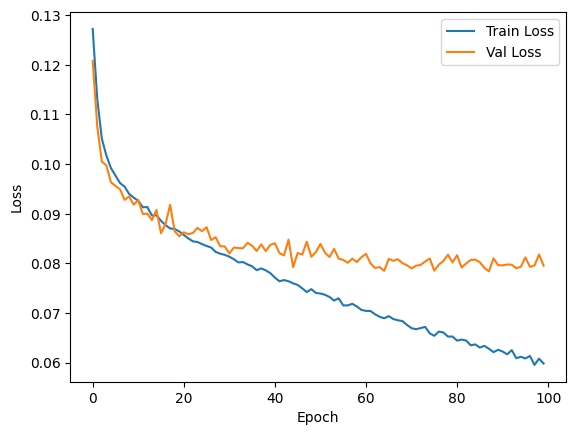

In [16]:
# plot train and validation accuracy
import matplotlib.pyplot as plt


def plot_acc(train_acc_hist, val_acc_hist):
    plt.plot(train_acc_hist, label='Train Acc')
    plt.plot(val_acc_hist, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss(train_loss_hist, val_loss_hist):
    plt.plot(train_loss_hist, label='Train Loss')
    plt.plot(val_loss_hist, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_acc(train_acc_hist, val_acc_hist)
plot_loss(train_loss_hist, val_loss_hist)

In [20]:
print(f"max train accuracy: {100*max(train_acc_hist):.2f}%")
print(f"max validation accuracy: {100*max(val_acc_hist):.2f}%")

max train accuracy: 70.86%
max validation accuracy: 60.70%
